# Animal spirits and the Goodwin pattern - Setterfield and Wheaton

This notebook provides the code needed to reproduce the figures in our paper. The source code for the ABM is located under the ..src/ directory and is used here to drive the simulations.

In [1]:
using Random
using Statistics
using CairoMakie
using DataFrames
using Distributed
using ProgressMeter
using CSV
using Glob

# 4 total procs, for parallel use of logical cores
# There is a bug with adding procs through Jupyter and the Julia env
#  See https://discourse.julialang.org/t/distributed-computing-not-found-package-error/34851
addprocs(3; exeflags=`--project=$(Base.active_project())`)
@everywhere using Agents, Agents.Graphs
foreach(include, glob("*.jl", "../src"))

In [10]:
# Manually run garbage collection (there seems to be a memory leak with Agents.jl, this helps prevent RAM from filling up)
GC.gc()
# Make sure only 4 procs running, otherwise restart kernel
procs()

4-element Vector{Int64}:
 1
 2
 3
 4

# Figure 2: Recurring cycles in a replication of Setterfield and Gouri Suresh (2015)

  0.232038 seconds (1.11 M allocations: 24.470 MiB, 90.99% compilation time: 98% of which was recompilation)


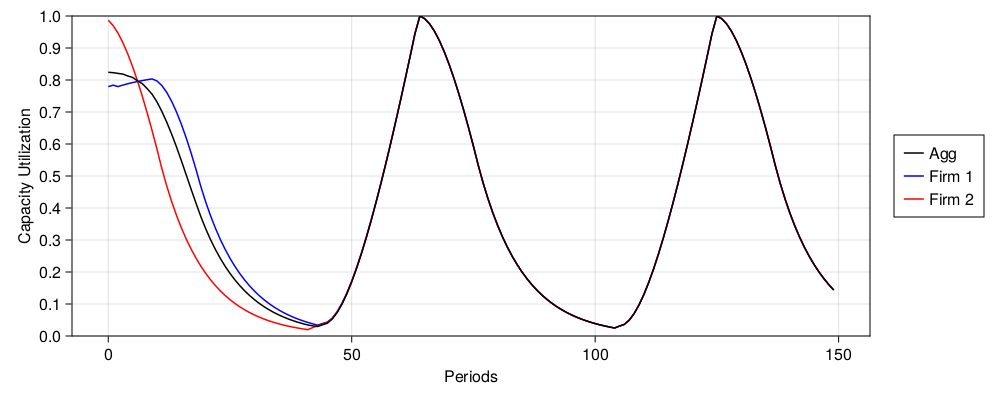

In [15]:
params = (;
    # Original Suresh-Setterfield model params
    n_firms = 500, # number of firms in simulation
    κ = 0.5, # the degree of isolation
    γ = 1.5, # the initial shock magnitude
    
    # Firm heterogeneities turned off
    het_α_lims = false,
    random_black_hole = false,
    
    seed = 3333 # Random seed
)
model = initialize_model(; params...)

@everywhere target_firm_utilization_1(a) = a isa Firm && a.id == 5 ? a.u : 0.0
@everywhere target_firm_utilization_2(a) = a isa Firm && a.id == 2 ? a.u : 0.0
@everywhere aggregate_utilization(model) = model.u[1]

adata = [(target_firm_utilization_1, sum), (target_firm_utilization_2, sum)]
mdata = [aggregate_utilization]

@time adf, mdf = run!(model, agent_step!, model_step!, 149; adata, mdata)

function plot_timeseries(adf, mdf)
    figure = Figure(resolution = (1000, 400))
    
    ax = figure[1, 1] = Axis(figure;
        xlabel = "Periods", ylabel = "Capacity Utilization", yticks = (0.0:0.1:1.0)
    )
    ylims!(ax, (0.0, 1.0))
    
    f1 = lines!(ax, mdf.step, adf.sum_target_firm_utilization_1, color = :blue)
    f2 = lines!(ax, mdf.step, adf.sum_target_firm_utilization_2, color = :red)
    agg = lines!(ax, mdf.step, mdf.aggregate_utilization, color = :black)
    figure[1, 2] = Legend(figure, [agg, f1, f2], ["Agg", "Firm 1", "Firm 2"])
    
    # Uncomment below to save this image to the ../images folder
    #save("../images/original_replication_cycles.pdf", figure, dpi=400)
    figure
end

plot_timeseries(adf, mdf)

# Figure 3: Recurring cycles with added heterogeneities

  0.206852 seconds (1.11 M allocations: 24.733 MiB, 92.21% compilation time: 98% of which was recompilation)


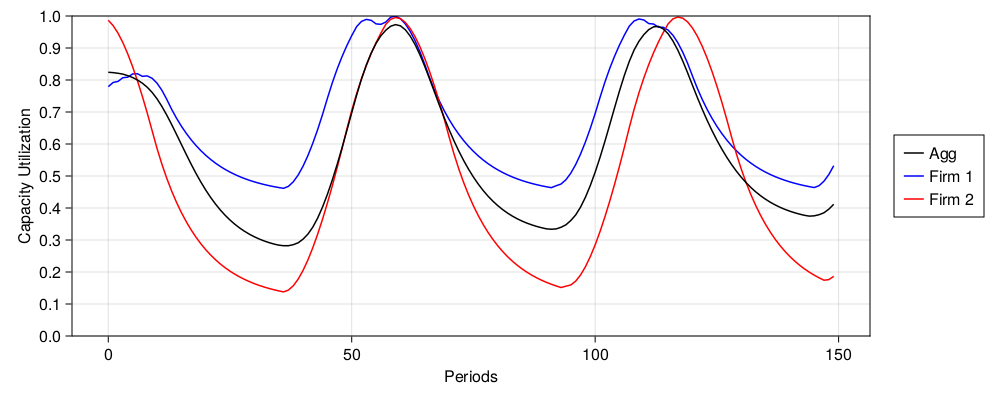

In [17]:
params = (;
    # Original Suresh-Setterfield model params
    n_firms = 500, # number of firms in simulation      
    κ = 0.5, # the degree of isolation
    γ = 1.5, # the initial shock magnitude
    
    # Added firm heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    seed = 3333 # random seed
)
model = initialize_model(; params...)

@everywhere target_firm_utilization_1(a) = a isa Firm && a.id == 5 ? a.u : 0.0
@everywhere target_firm_utilization_2(a) = a isa Firm && a.id == 2 ? a.u : 0.0
@everywhere aggregate_utilization(model) = model.u[1]

adata = [(target_firm_utilization_1, sum), (target_firm_utilization_2, sum)]
mdata = [aggregate_utilization]

@time adf, mdf = run!(model, agent_step!, model_step!, 149; adata, mdata)

function plot_timeseries(adf, mdf)
    figure = Figure(resolution = (1000, 400))
    
    ax = figure[1, 1] = Axis(figure;
        xlabel = "Periods", ylabel = "Capacity Utilization", yticks = (0.0:0.1:1.0)
    )
    ylims!(ax, (0.0, 1.0))
    
    f1 = lines!(ax, mdf.step, adf.sum_target_firm_utilization_1, color = :blue)
    f2 = lines!(ax, mdf.step, adf.sum_target_firm_utilization_2, color = :red)
    agg = lines!(ax, mdf.step, mdf.aggregate_utilization, color = :black)
    figure[1, 2] = Legend(figure, [agg, f1, f2], ["Agg", "Firm 1", "Firm 2"])
    
    #save("../images/original_replication_with_heterogeneities_cycles.pdf", figure, dpi=400)
    figure
end

plot_timeseries(adf, mdf)

# Figure 4: Moving Goodwin pattern in an animal spirits wage-led model

  0.663295 seconds (7.27 M allocations: 177.021 MiB, 74.54% compilation time: 2% of which was recompilation)


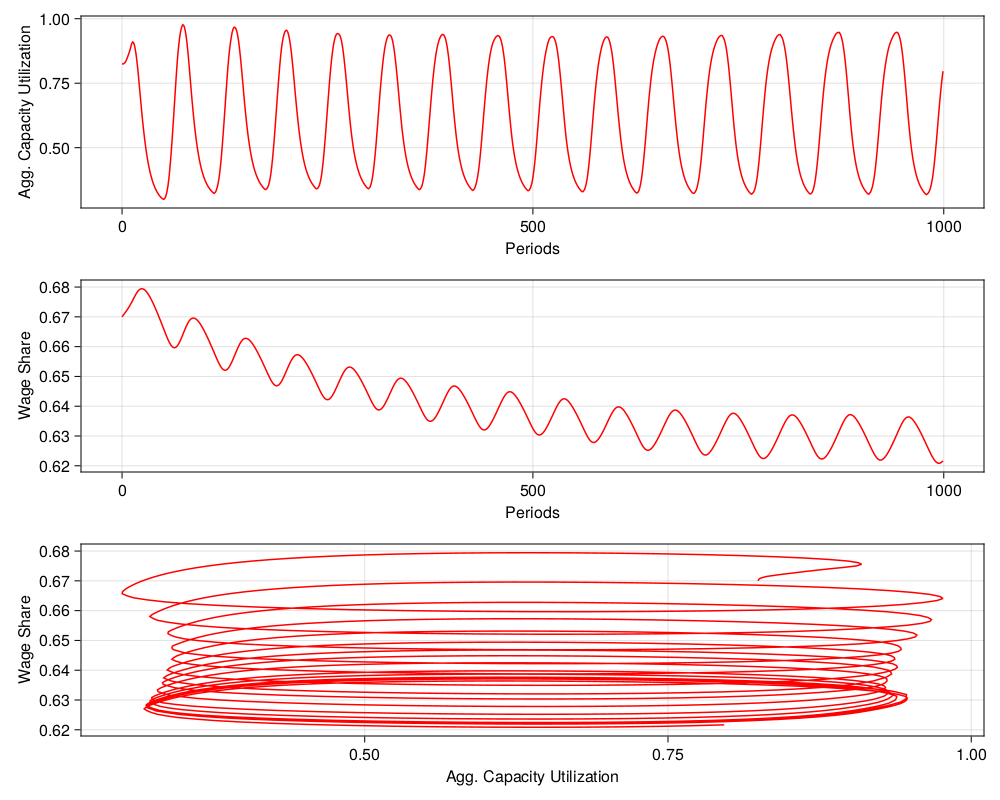

In [18]:
params = (;
    n_firms = 500, # number of firms in simulation
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015,
    
    seed = 1168 # random seed
)
model = initialize_model(; params...)

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

@time adf, mdf = run!(model, agent_step!, model_step!, 999; adata, mdata)

function plot_timeseries(adf, mdf)
    figure = Figure(resolution = (1000, 800))
    
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    agg = lines!(ax, mdf.step, mdf.aggregate_utilization, color = :red)
    
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    agg = lines!(ax, mdf.step, (1.0.-mdf.aggregate_profit_share), color = :red)
    
    ax = figure[3, 1] = Axis(figure; xlabel = "Agg. Capacity Utilization", ylabel = "Wage Share")
    agg = lines!(ax, mdf.aggregate_utilization, (1.0.-mdf.aggregate_profit_share), color = :red)
    
    #save("../images/reserve_army_effect_cycles.pdf", figure, dpi=400)
    figure
end

plot_timeseries(adf, mdf)

# Figure 5: A single cycle of the Goodwin pattern

  0.259608 seconds (6.60 M allocations: 134.603 MiB, 27.21% gc time, 9.51% compilation time: 38% of which was recompilation)


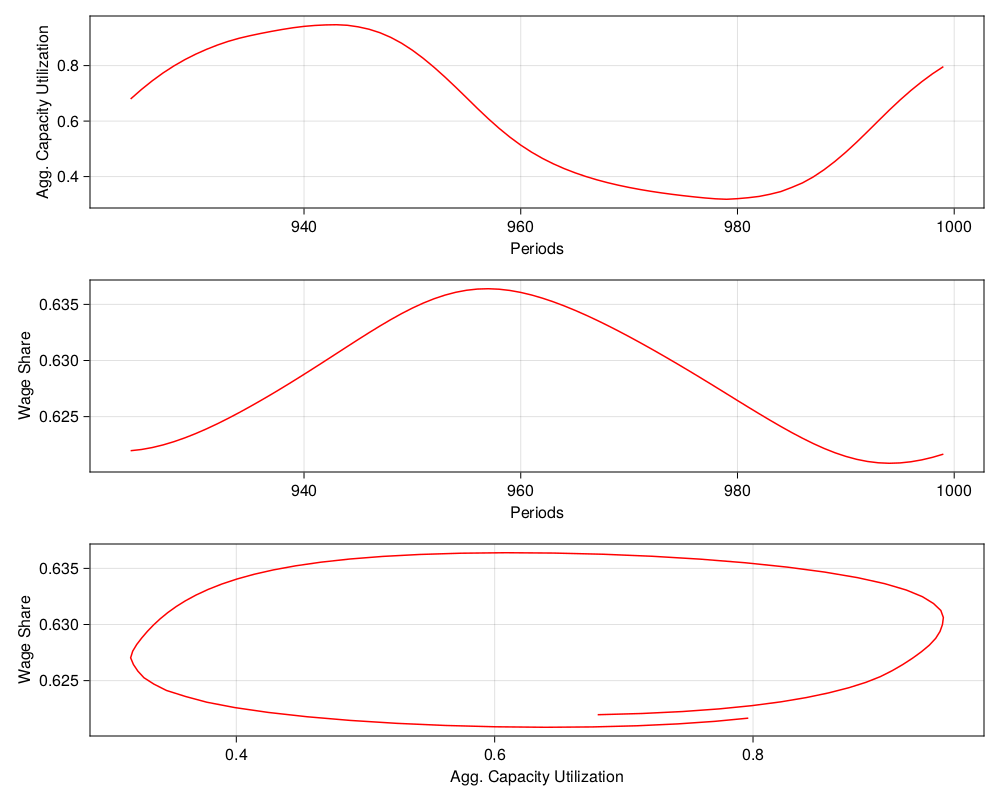

In [19]:
params = (;
    n_firms = 500, # number of firms in simulation      
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015,
    
    seed = 1168 # random seed
)
model = initialize_model(; params...)

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

@time adf, mdf = run!(model, agent_step!, model_step!, 999; adata, mdata)

function plot_timeseries(adf, mdf)
    figure = Figure(resolution = (1000, 800))
    
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    agg = lines!(ax, mdf.step[925:1000], mdf.aggregate_utilization[925:1000], color = :red)
    
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    agg = lines!(ax, mdf.step[925:1000], (1.0.-mdf.aggregate_profit_share[925:1000]), color = :red)
    
    ax = figure[3, 1] = Axis(figure; xlabel = "Agg. Capacity Utilization", ylabel = "Wage Share")
    agg = lines!(ax, mdf.aggregate_utilization[925:1000], (1.0.-mdf.aggregate_profit_share[925:1000]), color = :red)
    
    #save("../images/reserve_army_effect_cycles_last_cycle.pdf", figure, dpi=400)
    figure
end

plot_timeseries(adf, mdf)

# Figure 6: Sensitivity analysis of 1000 seeds
Running many simulations while changing the random seed to see if pattern is robust given the random heterogeneities.

In [21]:
params = (;
    n_firms = 500, # number of firms in simulation     
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015,
)
num_of_simulations = 1000

# Iterating 1000 seeds
models = [initialize_model(; seed = i, params...) for i in 1000:1:(1000+num_of_simulations-1)];

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

# Note: issue with kernel crashing sometimes due to memory usage (and potential memory leak)
# Make use of the GC.gc() command at top of notebook and resetting kernel
# Biggest culprit was returning adf, which is unnecessary for our purposes (and massive), so removed in call below

num_of_steps = 499
@time _,mdf = ensemblerun!(models, agent_step!, model_step!, num_of_steps; mdata, parallel = true)

 26.260654 seconds (11.38 M allocations: 338.782 MiB, 0.59% gc time)


(0×1 DataFrame
 Row │ ensemble 
     │ Int64    
─────┴──────────, 500000×4 DataFrame
    Row │ step   aggregate_utilization  aggregate_profit_share  ensemble 
        │ Int64  Float64                Float64                 Int64    
────────┼────────────────────────────────────────────────────────────────
      1 │     0               0.824176                0.33             1
      2 │     1               0.824214                0.329632         1
      3 │     2               0.824124                0.329263         1
      4 │     3               0.824726                0.328895         1
      5 │     4               0.826019                0.328526         1
      6 │     5               0.827902                0.328154         1
      7 │     6               0.830868                0.327779         1
      8 │     7               0.833093                0.327398         1
      9 │     8               0.833723                0.327012         1
     10 │     9               0.832

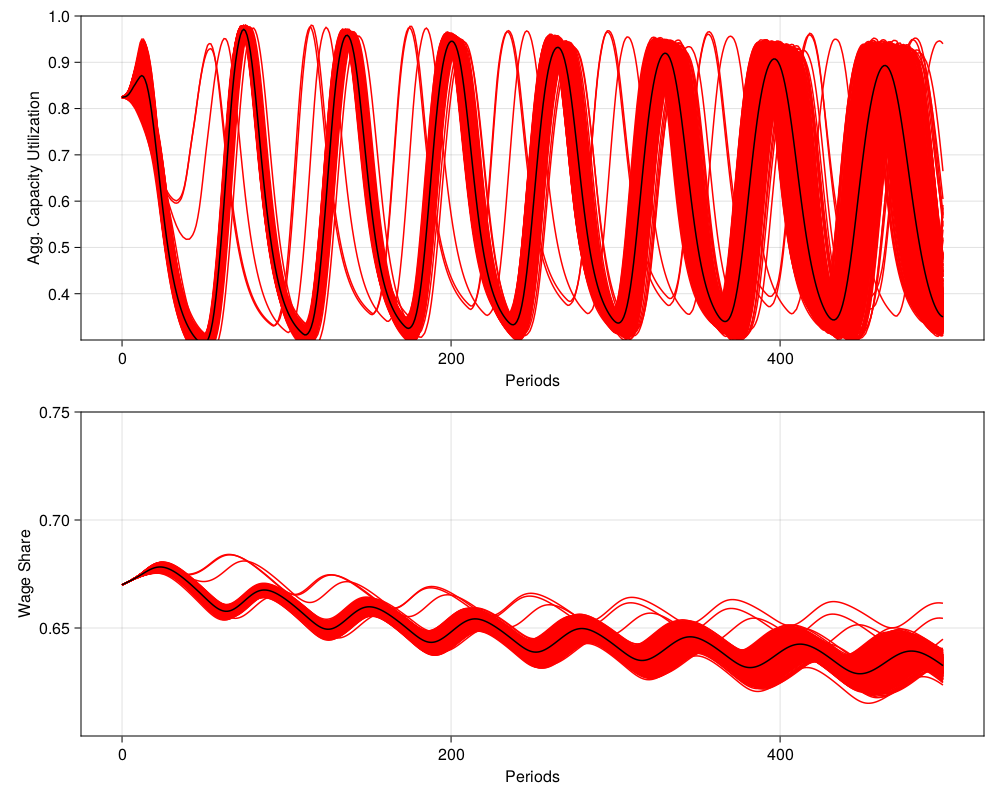

In [22]:
# Calculate the mean for each step across all simulations
grouped_mdf = groupby(mdf, :step)
agg_mdf = combine(grouped_mdf, :aggregate_utilization => mean, :aggregate_profit_share => mean)

function plot_timeseries(mdf)
    figure = Figure(resolution = (1000, 800))
    
    # Capacity utilizations
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    # Graph each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], 
            mdf.aggregate_utilization[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, agg_mdf.aggregate_utilization_mean, color = :black)
    ylims!(ax, (0.3, 1.0))
    
    # Wage shares
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    # Group each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))],
            (1.0.-mdf.aggregate_profit_share[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))]), color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, (1.0.-agg_mdf.aggregate_profit_share_mean), color = :black)
    ylims!(ax, (0.6, 0.75)) # crossing 0.75 is when Keynesian stability is broken!
    
    #save("../images/seed_sensitivity.pdf", figure, dpi=400)
    figure
end

plot_timeseries(mdf)

# Figure 7: Sensitivity analysis of 1000 seeds, with increase in reserve army mechanism parameter

In [23]:
params = (;
    n_firms = 500, # number of firms in simulation     
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0032, # increased this parameter
    v₃ = 0.0015,
)
num_of_simulations = 1000

# Iterating 1000 seeds
models = [initialize_model(; seed = i, params...) for i in 1000:1:(1000+num_of_simulations-1)];

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

# Note: issue with kernel crashing sometimes due to memory usage (and potential memory leak)
# Make use of the GC.gc() command at top of notebook and resetting kernel
# Biggest culprit was returning adf, which is unnecessary for our purposes (and massive), so removed in call below

num_of_steps = 499
@time _,mdf = ensemblerun!(models, agent_step!, model_step!, num_of_steps; mdata, parallel = true)

      From worker 2:	┌ Error: The Keynesian stability condition has been violated.
      From worker 2:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 3:	┌ Error: The Keynesian stability condition has been violated.
      From worker 3:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 2:	┌ Error: The Keynesian stability condition has been violated.
      From worker 2:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 4:	┌ Error: The Keynesian stability condition has been violated.
      From worker 4:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
 26.153764 seconds (11.38 M allocations: 341.091 MiB, 0.29% gc time)


(0×1 DataFrame
 Row │ ensemble 
     │ Int64    
─────┴──────────, 500000×4 DataFrame
    Row │ step   aggregate_utilization  aggregate_profit_share  ensemble 
        │ Int64  Float64                Float64                 Int64    
────────┼────────────────────────────────────────────────────────────────
      1 │     0               0.824176                0.33             1
      2 │     1               0.824352                0.329576         1
      3 │     2               0.824317                0.329152         1
      4 │     3               0.825227                0.328729         1
      5 │     4               0.827024                0.328303         1
      6 │     5               0.829753                0.327874         1
      7 │     6               0.83357                 0.327439         1
      8 │     7               0.836625                0.326996         1
      9 │     8               0.838412                0.326547         1
     10 │     9               0.838

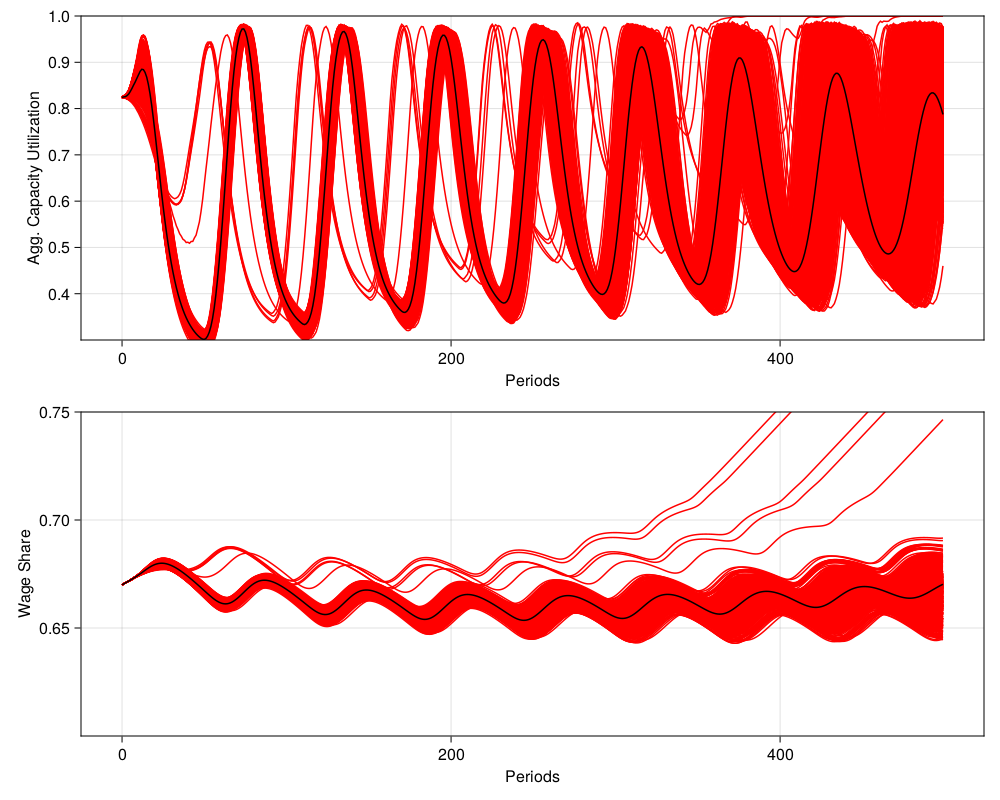

In [24]:
# Calculate the mean for each step across all simulations
grouped_mdf = groupby(mdf, :step)
agg_mdf = combine(grouped_mdf, :aggregate_utilization => mean, :aggregate_profit_share => mean)

function plot_timeseries(mdf)
    figure = Figure(resolution = (1000, 800))
    
    # Capacity utilizations
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    # Graph each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], 
            mdf.aggregate_utilization[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, agg_mdf.aggregate_utilization_mean, color = :black)
    ylims!(ax, (0.3, 1.0))
    
    # Wage shares
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    # Group each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))],
            (1.0.-mdf.aggregate_profit_share[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))]), color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, (1.0.-agg_mdf.aggregate_profit_share_mean), color = :black)
    ylims!(ax, (0.6, 0.75)) # crossing 0.75 is when Keynesian stability is broken!
    
    #save("../images/sensitivity_reserve_army.pdf", figure, dpi=400)
    figure
end

plot_timeseries(mdf)

# Figure 8: Sensitivity analysis of 1000 seeds, removing black hole heterogeneity

In [25]:
params = (;
    n_firms = 500, # number of firms in simulation    
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = false, # removing black hole heterogeneities
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015
)
num_of_simulations = 1000
models = [initialize_model(; seed = i, params...) for i in 1000:1:(1000+num_of_simulations-1)];

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

# Note: issue with kernel crashing sometimes due to memory usage (and potential memory leak)
# Make use of the GC.gc() command at top of notebook and resetting kernel
# Biggest culprit was returning adf, which is unnecessary for our purposes (and massive), so removed in call below

num_of_steps = 499
@time _,mdf = ensemblerun!(models, agent_step!, model_step!, num_of_steps; mdata, parallel = true)

      From worker 3:	┌ Error: The Keynesian stability condition has been violated.
      From worker 3:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 2:	┌ Error: The Keynesian stability condition has been violated.
      From worker 2:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 3:	┌ Error: The Keynesian stability condition has been violated.
      From worker 3:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 4:	┌ Error: The Keynesian stability condition has been violated.
      From worker 4:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From worker 3:	┌ Error: The Keynesian stability condition has been violated.
      From worker 3:	└ @ Main ~/julia-workspace/animal-spirits-goodwin-ABM/AnimalSpiritsGoodwinABM/src/abm.jl:163
      From work

(0×1 DataFrame
 Row │ ensemble 
     │ Int64    
─────┴──────────, 500000×4 DataFrame
    Row │ step   aggregate_utilization  aggregate_profit_share  ensemble 
        │ Int64  Float64                Float64                 Int64    
────────┼────────────────────────────────────────────────────────────────
      1 │     0               0.824176                0.33             1
      2 │     1               0.824657                0.329632         1
      3 │     2               0.824907                0.329262         1
      4 │     3               0.825682                0.328893         1
      5 │     4               0.828334                0.328522         1
      6 │     5               0.829522                0.328145         1
      7 │     6               0.833102                0.327766         1
      8 │     7               0.834617                0.32738          1
      9 │     8               0.839193                0.326991         1
     10 │     9               0.840

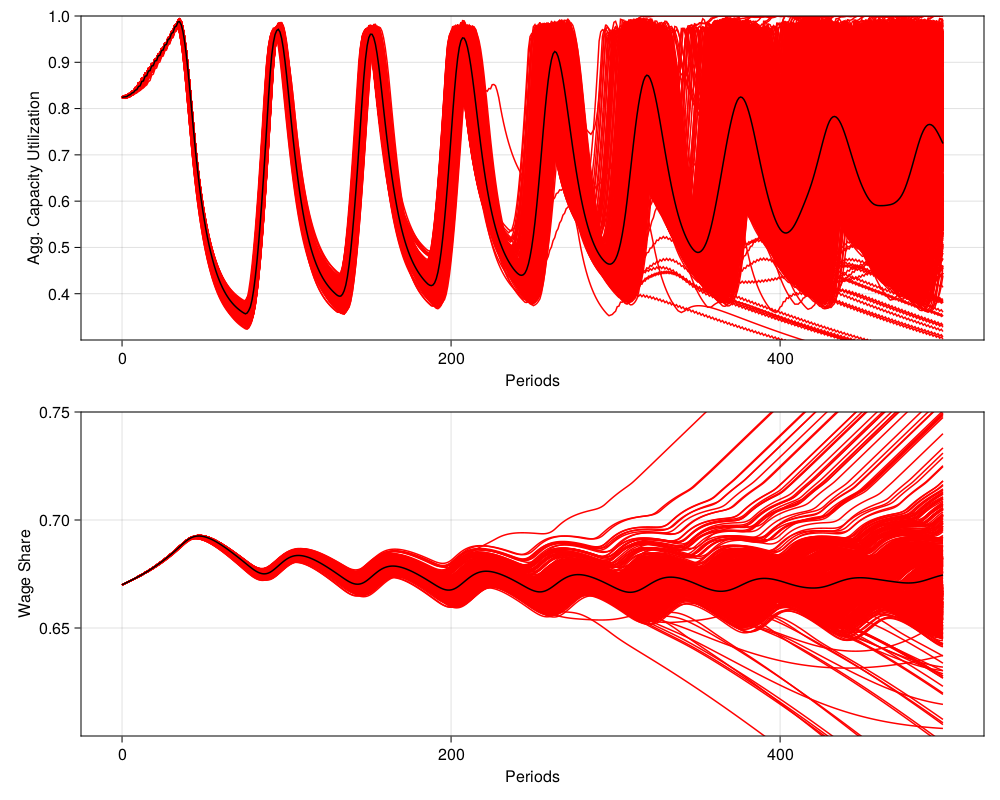

In [26]:
# Calculate the mean for each step across all simulations
grouped_mdf = groupby(mdf, :step)
agg_mdf = combine(grouped_mdf, :aggregate_utilization => mean, :aggregate_profit_share => mean)

function plot_timeseries(mdf)
    figure = Figure(resolution = (1000, 800))
    
    # Capacity utilizations
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    # Graph each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], 
            mdf.aggregate_utilization[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, agg_mdf.aggregate_utilization_mean, color = :black)
    ylims!(ax, (0.3, 1.0))
    
    # Wage shares
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))],
            (1.0.-mdf.aggregate_profit_share[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))]), color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, (1.0.-agg_mdf.aggregate_profit_share_mean), color = :black)
    ylims!(ax, (0.6, 0.75)) # crossing 0.75 is when Keynesian stability is broken!
    
    #save("../images/sensitivity_black_hole_heterogeneity.pdf", figure, dpi=400)
    figure
end

plot_timeseries(mdf)

# Figure 9: Sensitivity analysis of 1000 seeds, removing both heterogeneities (replication of Setterfield and Suresh 2015 with added reserve army effect)

In [27]:
params = (;
    n_firms = 500, # number of firms in simulation     
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = false, # removing heterogeneity of animal spirit thresholds
    random_black_hole = false, # removing black hole heterogeneity
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015
)
num_of_simulations = 1000
models = [initialize_model(; seed = i, params...) for i in 1000:1:(1000+num_of_simulations-1)];

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

# Note: issue with kernel crashing sometimes due to memory usage (and potential memory leak)
# Make use of the GC.gc() command at top of notebook and resetting kernel
# Biggest culprit was returning adf, which is unnecessary for our purposes (and massive), so removed in call below

num_of_steps = 499
@time _,mdf = ensemblerun!(models, agent_step!, model_step!, num_of_steps; mdata, parallel = true)

 25.170823 seconds (11.38 M allocations: 339.521 MiB)


(0×1 DataFrame
 Row │ ensemble 
     │ Int64    
─────┴──────────, 500000×4 DataFrame
    Row │ step   aggregate_utilization  aggregate_profit_share  ensemble 
        │ Int64  Float64                Float64                 Int64    
────────┼────────────────────────────────────────────────────────────────
      1 │     0               0.824176                0.33             1
      2 │     1               0.824657                0.329632         1
      3 │     2               0.824907                0.329262         1
      4 │     3               0.825682                0.328893         1
      5 │     4               0.828334                0.328522         1
      6 │     5               0.829522                0.328145         1
      7 │     6               0.833102                0.327766         1
      8 │     7               0.834617                0.32738          1
      9 │     8               0.839193                0.326991         1
     10 │     9               0.840

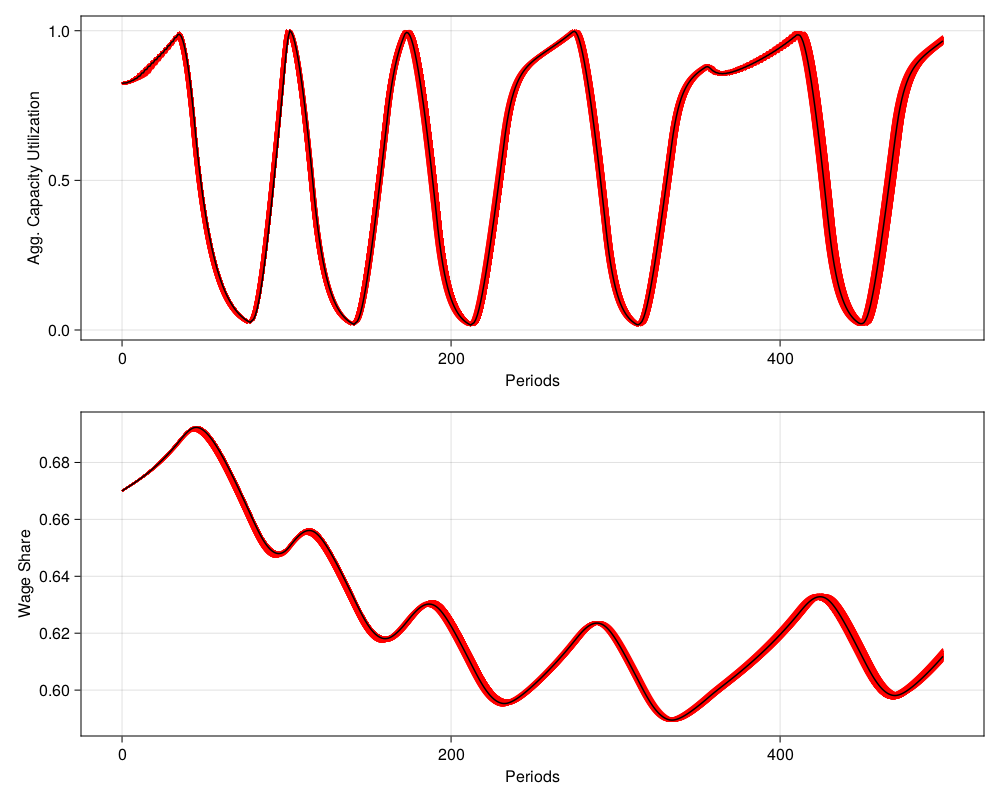

In [28]:
# Calculate the mean for each step across all simulations
grouped_mdf = groupby(mdf, :step)
agg_mdf = combine(grouped_mdf, :aggregate_utilization => mean, :aggregate_profit_share => mean)

function plot_timeseries(mdf)
    figure = Figure(resolution = (1000, 800))
    
    # Capacity utilizations
    ax = figure[1, 1] = Axis(figure; xlabel = "Periods", ylabel = "Agg. Capacity Utilization")
    # Graph each individual simulation
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], 
            mdf.aggregate_utilization[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))], color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, agg_mdf.aggregate_utilization_mean, color = :black)
    #ylims!(ax, (0.3, 1.0))
    
    # Wage shares
    ax = figure[2, 1] = Axis(figure; xlabel = "Periods", ylabel = "Wage Share")
    for i in 1:num_of_simulations
        agg = lines!(ax, mdf.step[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))],
            (1.0.-mdf.aggregate_profit_share[((i-1)*(num_of_steps+1)+1):(i*(num_of_steps+1))]), color = :red)
    end
    # Add the means across simulations
    agg = lines!(ax, agg_mdf.step, (1.0.-agg_mdf.aggregate_profit_share_mean), color = :black)
    
    #save("../images/sensitivity_no_heterogeneities.pdf", figure, dpi=400)
    figure
end

plot_timeseries(mdf)

# Extra: Printing out time series of pseudo Goodwin pattern, for use in any econometric work

In [20]:
params = (;
    n_firms = 500, # number of firms in simulation    
    κ = 0.5, # the degree of isolation
    γ = 0.5, # the initial shock magnitude
    
    # Added heterogeneities
    het_α_lims = true,
    random_black_hole = true,
    
    # Added reserve army effect
    reserve_army_effect = true,
    v₁ = 0.001,
    v₂ = 0.0031,
    v₃ = 0.0015,
    
    seed = 1168 # random seed
)
model = initialize_model(; params...)

@everywhere aggregate_utilization(model) = model.u[1]
@everywhere aggregate_profit_share(model) = model.Π[1]

adata = []
mdata = [aggregate_utilization, aggregate_profit_share]

@time adf, mdf = run!(model, agent_step!, model_step!, 999; adata, mdata)

# Take every other element, to more closely approximate a quarterly dataset
#  Reasoning: there are 7.5 cycles in these 500 datapoints
#  A "business cycle" traditionally lasts ~8 yrs
#  Out dataset is thus ~60 yrs, meaning ~8 datapoints/yr, so divide by 2 for "quarterly"

utils = mdf.aggregate_utilization[500:2:1000]
laborshares = (1.0.-mdf.aggregate_profit_share[500:2:1000])
df = DataFrame(CapacityUtilization=utils, LaborShare=laborshares)

#CSV.write("../data/wageled_goodwin.csv", df)

  0.513311 seconds (6.60 M allocations: 134.590 MiB, 18.11% compilation time: 50% of which was recompilation)


Row,CapacityUtilization,LaborShare
,Float64,Float64
1,0.366686,0.632998
2,0.407456,0.632005
3,0.466392,0.631194
4,0.53869,0.63063
5,0.617508,0.630359
6,0.693908,0.630396
7,0.761231,0.630723
8,0.815877,0.631302
9,0.857891,0.632081
